# **Subset CONUS and run ParFlow-CLM**

To launch this notebook interactively in a Jupyter notebook-like browser interface, please click the "Launch Binder" button below. Note that Binder may take several minutes to launch.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/hydroframe/subsettools-binder/HEAD?labpath=subsettools%2Fconus2_subsetting_transient.ipynb)

This notebook walks through an example of subsetting a HUC8 from the CONUS2 domain. This example will subset everything needed to do a transient run with ParFlow-CLM. 
This is includes all hydrogeologic datasets as well as climate forcing data from CW3E. All of the data is written to a folder for the specified days to run. This example uses the template runscript conus2_pfclm_transient_solid.yaml and edits it to correspond with the domain subset. It also sets-up and performs the designed simulation. The result will be model output pressure and saturation pfbs according to the days specified.

### This notebook has two principal sections: 
1. Subset all static inputs and climate forcings from a CONUS run stored in Hydrodata 
2. Load and alter a reference run to set up and perform your ParFlow-CLM subset.

### Import the required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from parflow import Run
from parflow.tools.io import read_pfb, read_clm
from parflow.tools.fs import mkdir
from parflow.tools.settings import set_working_directory
import subsettools as st
import hf_hydrodata as hf

In [2]:
# You need to register on https://hydrogen.princeton.edu/pin before you can use the hydrodata utilities
hf.register_api_pin("your_email", "your_pin")

### 1. Define variables to access datasets in Hydrodata to subset and define write paths

#### We will be testing with the Middle James-Buffalo watershed in Virginia for this example

REMEMBER: CONUS 1 and 2 have different domains, a HUC that will run in CONUS2 may not be in the CONUS1 domain

- HUC ID: 02080203
- Size: 5240 km^2 (ni = 91, nj = 89)   

#### Set your variables to specify which static and climate forcing data you would like to subset in Hydrodata

In [3]:
runname = "conus2_mjb"

# provide a way to create a subset from the conus domain (huc, lat/lon bbox currently supported)
hucs = ["02080203"]
# provide information about the datasets you want to access for run inputs using the data catalog
start = "2005-10-01"
end = "2005-10-03"
grid = "conus2"
var_ds = "conus2_domain"
forcing_ds = "CW3E"
# cluster topology
P = 1
Q = 1

# set the directory paths where you want to write your subset files
home = os.path.expanduser("~")
base_dir = os.path.join(home, "subsettools_tutorial")
input_dir = os.path.join(base_dir, "inputs", f"{runname}_{grid}_{end[:4]}WY")
output_dir = os.path.join(base_dir, "outputs")
static_write_dir = os.path.join(input_dir, "static")
mkdir(static_write_dir)
forcing_dir = os.path.join(input_dir, "forcing")
mkdir(forcing_dir)
pf_out_dir = os.path.join(output_dir, f"{runname}_{grid}_{end[:4]}WY")
mkdir(pf_out_dir)

# Set the PARFLOW_DIR path to your local installation of ParFlow.
# This is only necessary if this environment variable is not already set.
# os.environ["PARFLOW_DIR"] = "/path/to/your/parflow/installation"

# load your preferred template runscript
reference_run = st.get_template_runscript(grid, "transient", "solid", pf_out_dir)

### 2. Get the desired ParFlow i/j bbox from user provided geospatial information 

In [5]:
ij_bounds, mask = st.define_huc_domain(hucs=hucs, grid=grid)
print("ij_bound returns [imin, jmin, imax, jmax]")
print(f"bounding box: {ij_bounds}")

nj = ij_bounds[3] - ij_bounds[1]
ni = ij_bounds[2] - ij_bounds[0]
print(f"nj: {nj}")
print(f"ni: {ni}")

ij_bound returns [imin, jmin, imax, jmax]
bounding box: (3701, 1544, 3792, 1633)
nj: 89
ni: 91


### 3. Make the mask and solid file
You only do this if you providin a huc or list of hucs. Otherwise, the reference run provided is for a box domain.

In [10]:
mask_solid_paths = st.write_mask_solid(mask=mask, grid=grid, write_dir=static_write_dir)

Wrote mask.pfb
Wrote solidfile and mask_vtk with total z of 2000 meters


### 4. Subset the static ParFlow inputs
Two options to subset static inputs. 
1. subset_static(): This function when provided with a variable dataset hosted on Hydrodata will subset all static inputs required to do a baseline run from the default argument var_list without the user specifying specific files. Pressure is the steady state pressure. If a user would like the override this, they may pass in their own value for var_list and their specifed variables in the target dataset will be subset. 

2. subset_press_init(): This function will write the subset pressure of the last hour in the last day before your start date in the given time zone. If no such pressure file exists in the hydrodata run dataset specifed, no file will be written. The function assumes UTC0 as the default and will return 11PM UTC0. You can override this by providing a timezone. 

**Note: In when working with the CONUS2 domain, there are no currently no available transient runs, so we will start runs from the steady state pressure file returned by subset_static().** 

In [11]:
static_paths = st.subset_static(ij_bounds, dataset=var_ds, write_dir=static_write_dir)

Wrote slope_x.pfb in specified directory.
Wrote slope_y.pfb in specified directory.
Wrote pf_indicator.pfb in specified directory.
Wrote mannings.pfb in specified directory.
Wrote pf_flowbarrier.pfb in specified directory.
Wrote pme.pfb in specified directory.
Wrote ss_pressure_head.pfb in specified directory.


### 5. Configure CLM drivers
This function will get the clm drivers that are associated with your run dataset (same dataset as where you got your initial pressure file). Vegm, vegp and drv_clmin will be written into your specified static input directory. 

In [12]:
clm_paths = st.config_clm(ij_bounds, start=start, end=end, dataset=var_ds, write_dir=static_write_dir)

copied vegp
subset vegm
copied drv_clmin
edited drv_clmin


### 6. Subset the climate forcing

This function will write all variables needed to run CLM for your specified forcing dataset, on your specified grid, subset to the i/j boundary that was returned previously within the specified start and end date. This function assumes UTC0 by default, but you can override it by providing a timezone.

In [13]:
forcing_paths = st.subset_forcing(
    ij_bounds,
    grid=grid,
    start=start,
    end=end,
    dataset=forcing_ds,
    write_dir=forcing_dir,
)

Reading precipitation pfb sequence
Reading downward_shortwave pfb sequence
Reading downward_longwave pfb sequence
Reading specific_humidity pfb sequence
Reading air_temp pfb sequence
Reading atmospheric_pressure pfb sequence
Reading east_windspeed pfb sequence
Reading north_windspeed pfb sequence
Finished writing downward_longwave to folder
Finished writing north_windspeed to folder
Finished writing downward_shortwave to folder
Finished writing precipitation to folder
Finished writing east_windspeed to folder
Finished writing specific_humidity to folder
Finished writing atmospheric_pressure to folder
Finished writing air_temp to folder


### 7. Spot check subset static and climate forcing with plotting

#### Check a static input

(89, 91)


Text(0.5, 1.0, 'pf_indicator.pfb')

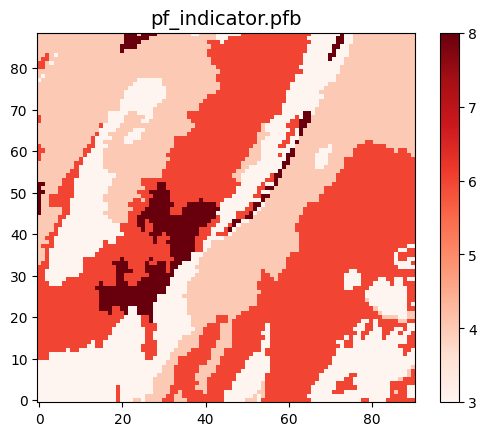

In [14]:
os.chdir(static_write_dir)
file_name = "pf_indicator.pfb"
data = read_pfb(file_name)[7] 
print(data.shape)

plt.imshow(data, cmap="Reds", origin="lower")
plt.colorbar()
plt.title(file_name, fontsize = 14)

### 8. Set up a baseline run from a reference yaml
This function will return the correct template yaml file to do your run based on the grid, if you're doing spin-up and if you're using a solid file with the necessary keys changed to run your subset with selected climate forcing at baseline for your specified start and end dates.

In [15]:
runscript_path = st.edit_runscript_for_subset(
    ij_bounds,
    runscript_path=reference_run,
    runname=runname,
    forcing_dir=forcing_dir,
)

Solver: Field BinaryOutDir is not part of the expected schema <class 'parflow.tools.database.generated.Solver'>
New runname: conus2_mjb provided, a new yaml file will be created
Climate forcing directory has been changed to /home/ga6/subsettools_tutorial/inputs/conus2_mjb_conus2_2005WY/forcing  in runscript.
ComputationalGrid.NY set to 89 and NX to 91
GeomInput.domaininput.InputType detected as SolidFile, no additional keys to change for subset
Updated runscript written to /home/ga6/subsettools_tutorial/outputs/conus2_mjb_conus2_2005WY


### 9. Copy over your static files to your run directory
You may only need to do this once, or you may want to copy subset static files to different run directories for different runs.

In [16]:
st.copy_files(read_dir=static_write_dir, write_dir=pf_out_dir)

### 10. Change the file names in your runscript if desired
If you have changed the name of a static input file either from those used in the reference yamls provided, or have changed the name of an individual file for an ensemble or other experiment, you can change it with this function by providing the target runscript (yaml or pfidb) and the new file name(s) as an arguments. Only those arguments with a specified file name will be updated

In [17]:
init_press_path = os.path.basename(static_paths["ss_pressure_head"])
depth_to_bedrock_path = os.path.basename(static_paths["pf_flowbarrier"])

runscript_path = st.change_filename_values(
    runscript_path=runscript_path,
    init_press=init_press_path,
    depth_to_bedrock = depth_to_bedrock_path
)

Solver: Field BinaryOutDir is not part of the expected schema <class 'parflow.tools.database.generated.Solver'>
Initial pressure filename changed to ss_pressure_head.pfb
Depth to bedrock filename changed to pf_flowbarrier.pfb
Updated runscript written to /home/ga6/subsettools_tutorial/outputs/conus2_mjb_conus2_2005WY


### 11. Change processor topology if desired and then distribute your inputs and forcings to match the new topology

In [18]:
runscript_path = st.dist_run(
    topo_p=P,
    topo_q=Q,
    runscript_path=runscript_path,
    dist_clim_forcing=True,
)

Solver: Field BinaryOutDir is not part of the expected schema <class 'parflow.tools.database.generated.Solver'>
Distributing your climate forcing
Distributed mask.pfb with NZ 1
Distributed slope_x.pfb with NZ 1
Distributed slope_y.pfb with NZ 1
Distributed pf_indicator.pfb with NZ 10
Distributed mannings.pfb with NZ 1
Distributed pf_flowbarrier.pfb with NZ 1
Distributed pme.pfb with NZ 10
Distributed ss_pressure_head.pfb with NZ 10


### 12. Do a baseline run.
Load in the yaml run file you've created which is in the same folder as your static forcings and points to your climate forcing data. This assumes you do not want to make any changes from the parent model you used (Ex. conus1 baseline) and will run your subset at baseline conditions. Outputs should be almost identical to the parent model at your subset location for the same time period if you make no additional changes.

**Notes about run speed**

There are several things that may cause your run to take longer than expect. First, look at the file ending with your_runname.out.kinsol.log. If it is updating, it means your system is trying to solve. 

1. You may be trying to run too large a domain for the number of cores 
2. There is heavy rain on the day or days you selected, making the system harder to solve
3. The initial (time 0) step can often take longer to run
4. You have made a large change to one of your inputs. The change you made may mean the initial pressure file doesn't "match up" with your input. Try to run your subset model in spinup mode first, and then return to transient mode.

In [19]:
set_working_directory(f"{pf_out_dir}")
print(pf_out_dir)

# load the specified run script
run = Run.from_definition(runscript_path)
print(f"Loaded run with runname: {run.get_name()}")

# The following line is setting the run just for 10 hours for testing purposes
run.TimingInfo.StopTime = 10

# The following line updates the root name of your climate forcing. You can comment it out if using NLDAS datasets. 
run.Solver.CLM.MetFileName = 'CW3E'

run.run(working_directory=pf_out_dir)

/home/ga6/subsettools_tutorial/outputs/conus2_mjb_conus2_2005WY
Solver: Field BinaryOutDir is not part of the expected schema <class 'parflow.tools.database.generated.Solver'>
Loaded run with runname: conus2_mjb

# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/3.10.0
# ParFlow version
#  - 3.10.0
# Working directory
#  - /home/ga6/subsettools_tutorial/outputs/conus2_mjb_conus2_2005WY
# ParFlow database
#  - conus2_mjb.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

